In [1]:
!nvidia-smi

Mon Mar  1 09:10:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!tar xzvf '/content/drive/MyDrive/UTKFace.tar.gz'

ストリーミング出力は最後の 5000 行に切り捨てられました。
UTKFace/33_1_0_20170111182452825.jpg.chip.jpg
UTKFace/26_1_1_20170116024053194.jpg.chip.jpg
UTKFace/25_1_0_20170109213232182.jpg.chip.jpg
UTKFace/28_1_1_20170112234526480.jpg.chip.jpg
UTKFace/57_0_0_20170117191704100.jpg.chip.jpg
UTKFace/27_1_1_20170117193211345.jpg.chip.jpg
UTKFace/46_1_1_20170116161237892.jpg.chip.jpg
UTKFace/24_0_2_20170116171647508.jpg.chip.jpg
UTKFace/42_1_1_20170113005712902.jpg.chip.jpg
UTKFace/25_1_1_20170116001337504.jpg.chip.jpg
UTKFace/40_1_0_20170116222110661.jpg.chip.jpg
UTKFace/50_1_0_20170109012257664.jpg.chip.jpg
UTKFace/26_1_3_20170104235421282.jpg.chip.jpg
UTKFace/7_0_0_20170110215711115.jpg.chip.jpg
UTKFace/1_1_2_20161219155353413.jpg.chip.jpg
UTKFace/26_0_1_20170117195651493.jpg.chip.jpg
UTKFace/7_0_0_20170110215648859.jpg.chip.jpg
UTKFace/64_0_0_20170117155540137.jpg.chip.jpg
UTKFace/48_0_0_20170109004813150.jpg.chip.jpg
UTKFace/39_0_0_20170103183230555.jpg.chip.jpg
UTKFace/45_0_1_20170117190019363.jpg.chip.jpg
UTKFa

In [4]:
!pip install torch-summary

In [5]:
import os
import random
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import torchsummary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython import display
from PIL import Image
from glob import glob

In [6]:
EPOCHS = 1000
BATCH_SIZE = 64
IMAGE_SIZE = 64
DEVICE = 'cuda'

In [7]:
paths = sorted(glob('./UTKFace/*'))
paths = pd.DataFrame(paths, columns=['path'])
label = paths.path.str.extract('./UTKFace/(?P<age>\d+)_(?P<gender>\d+)_(?P<race>\d+)_', expand=True)

age = label.age.astype('float')
age = age.clip(0,70)
age_mean = age.mean()
age_std = age.std()
age = (age-age_mean) / age_std
print(age.min(), age.max())
gender = pd.get_dummies(label.gender)
race = pd.get_dummies(label.race)
df = pd.concat([paths, age, gender, race], axis=1)
df = df.sample(frac=1, random_state=1919).reset_index(drop=True)
df = df.dropna()
num_test = 10
train_df = df[:-num_test]
test_df = df[-num_test:]
CLASSES = len(train_df.columns) - 1
print('class', CLASSES)
print(len(df), len(train_df), len(test_df))
train_df


-1.7122222708769117 2.01187943992014
class 8
23705 23695 10


path       age  0  ...  2  3  4
0      ./UTKFace/23_1_2_20170102235032243.jpg.chip.jpg -0.524828  0  ...  1  0  0
1      ./UTKFace/37_0_0_20170116200645679.jpg.chip.jpg  0.230787  1  ...  0  0  0
2      ./UTKFace/40_0_4_20170117135456629.jpg.chip.jpg  0.392705  1  ...  0  0  1
3      ./UTKFace/88_1_0_20170120225747122.jpg.chip.jpg  2.011879  0  ...  0  0  0
4      ./UTKFace/26_1_0_20170117195825620.jpg.chip.jpg -0.362910  0  ...  0  0  0
...                                                ...       ... ..  ... .. .. ..
23693  ./UTKFace/40_1_0_20170117181413925.jpg.chip.jpg  0.392705  0  ...  0  0  0
23694  ./UTKFace/34_1_3_20170119163642029.jpg.chip.jpg  0.068870  0  ...  0  1  0
23695  ./UTKFace/30_1_0_20170117181332132.jpg.chip.jpg -0.147020  0  ...  0  0  0
23696  ./UTKFace/28_0_1_20170117172812224.jpg.chip.jpg -0.254965  1  ...  0  0  0
23697   ./UTKFace/5_0_2_20161219151837283.jpg.chip.jpg -1.496332  1  ...  1  0  0

[23695 rows x 9 columns]

In [8]:
train_transform = transforms.Compose([
                               transforms.Resize(IMAGE_SIZE, Image.BICUBIC),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

test_transform = transforms.Compose([
                               transforms.Resize(IMAGE_SIZE, Image.BICUBIC),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

In [9]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, df, transform):
        self.transform = transform
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        d = self.df.iloc[idx]
        label = torch.Tensor(d[1:]).float()
        image = Image.open(d.path).convert('RGB')
        image = self.transform(image)
        return image, label

tensor([[-0.9026,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.6626,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.9324,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [-1.1185,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 1.3642,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 2.0119,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.3089,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 1.3642,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.3642,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [-0.5788,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [ 0.9324,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [-0.3089,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [-0.3629

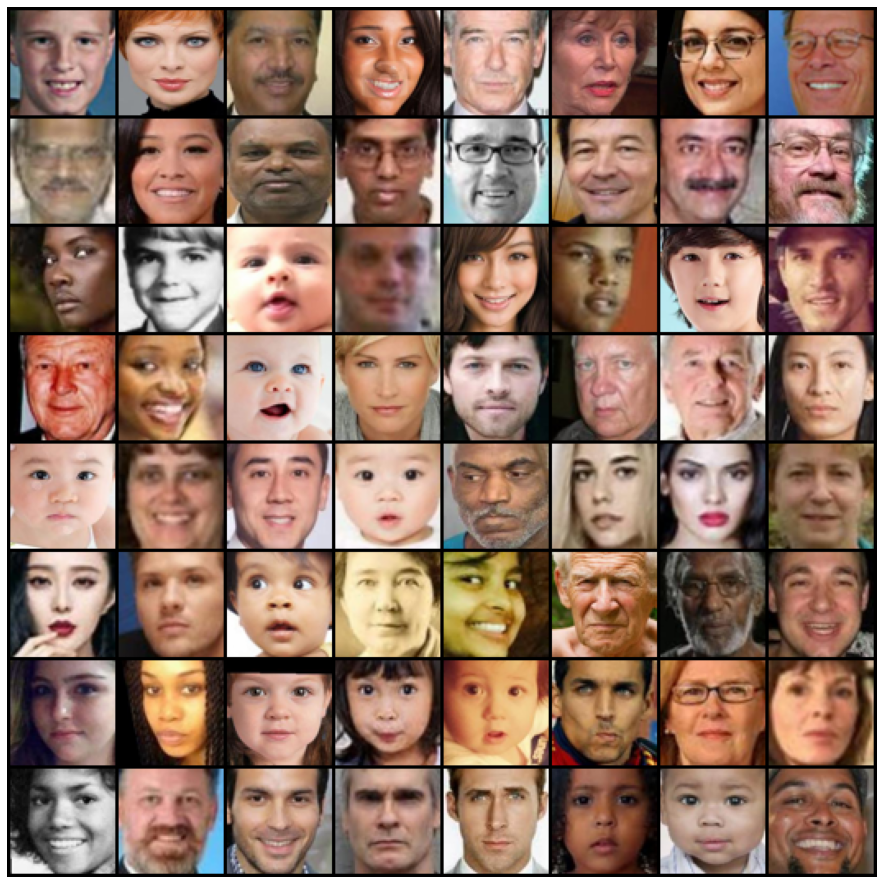

In [10]:
train_ds = Mydatasets(train_df, train_transform)
train_ds = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=os.cpu_count(), drop_last=True, pin_memory=True)

test_ds = Mydatasets(test_df, test_transform)
test_ds = torch.utils.data.DataLoader(test_ds, batch_size=num_test,
                                         shuffle=False, num_workers=0, drop_last=True)
                                         
d = next(iter(train_ds))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(d[0], padding=2, normalize=True).cpu(),(1,2,0)))
print(d[1])

In [11]:
class DownBlock(nn.Module):
    def __init__(self, fin, fout, use_norm=True):
        super().__init__()

        self.use_norm = use_norm
        self.conv = nn.Conv2d(fin, fout, 3, stride=2, padding=1)
        if self.use_norm:
            self.norm = nn.InstanceNorm2d(fout)
    
    def forward(self, x):
        x = self.conv(x)
        if self.use_norm:
            x = self.norm(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        return x

class UpBlock(nn.Module):
    def __init__(self, fin, fout, use_norm=True):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(fin+CLASSES, fin, 3, stride=1, padding=1),
            nn.InstanceNorm2d(fin),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(fin, fout, 4, stride=2, padding=1),
            nn.InstanceNorm2d(fout),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def label_to_image(self, label, SIZE):
        return label.view(-1, CLASSES, 1, 1).expand(-1, CLASSES, SIZE, SIZE)
    
    def forward(self, x, label):
        l = self.label_to_image(label, x.size(2))
        x = torch.cat([x, l], dim=1)
        x = self.main(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            DownBlock(3, 64, use_norm=False),
            DownBlock(64, 128),
            DownBlock(128, 256),
            DownBlock(256, 512),
        )

        self.up1 = UpBlock(512, 256)
        self.up2 = UpBlock(256, 128)
        self.up3 = UpBlock(128, 64)
        self.up4 = UpBlock(64, 64)

        self.image = nn.Sequential(
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, x, y):
        x = self.encoder(x)
        x = self.up1(x, y)
        x = self.up2(x, y)
        x = self.up3(x, y)
        x = self.up4(x, y)
        x = self.image(x)
        return x

In [12]:
netG = Generator().to(DEVICE)
torchsummary.summary(netG, [(3,IMAGE_SIZE,IMAGE_SIZE), (CLASSES,)])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 4, 4]           --
|    └─DownBlock: 2-1                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          1,792
|    └─DownBlock: 2-2                    [-1, 128, 16, 16]         --
|    |    └─Conv2d: 3-2                  [-1, 128, 16, 16]         73,856
|    |    └─InstanceNorm2d: 3-3          [-1, 128, 16, 16]         --
|    └─DownBlock: 2-3                    [-1, 256, 8, 8]           --
|    |    └─Conv2d: 3-4                  [-1, 256, 8, 8]           295,168
|    |    └─InstanceNorm2d: 3-5          [-1, 256, 8, 8]           --
|    └─DownBlock: 2-4                    [-1, 512, 4, 4]           --
|    |    └─Conv2d: 3-6                  [-1, 512, 4, 4]           1,180,160
|    |    └─InstanceNorm2d: 3-7          [-1, 512, 4, 4]           --
├─UpBlock: 1-2                           [-1, 256, 8, 8]          

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 4, 4]           --
|    └─DownBlock: 2-1                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          1,792
|    └─DownBlock: 2-2                    [-1, 128, 16, 16]         --
|    |    └─Conv2d: 3-2                  [-1, 128, 16, 16]         73,856
|    |    └─InstanceNorm2d: 3-3          [-1, 128, 16, 16]         --
|    └─DownBlock: 2-3                    [-1, 256, 8, 8]           --
|    |    └─Conv2d: 3-4                  [-1, 256, 8, 8]           295,168
|    |    └─InstanceNorm2d: 3-5          [-1, 256, 8, 8]           --
|    └─DownBlock: 2-4                    [-1, 512, 4, 4]           --
|    |    └─Conv2d: 3-6                  [-1, 512, 4, 4]           1,180,160
|    |    └─InstanceNorm2d: 3-7          [-1, 512, 4, 4]           --
├─UpBlock: 1-2                           [-1, 256, 8, 8]          

In [13]:
class DownBlock(nn.Module):
    def __init__(self, fin, fout):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(fin, fout, 3, stride=2, padding=1),
            nn.InstanceNorm2d(fout),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(fout, fout, 3, stride=1, padding=1),
            nn.InstanceNorm2d(fout),
            nn.LeakyReLU(0.2, inplace=True),
        )
    
    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3+CLASSES, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            DownBlock(64, 64),
            DownBlock(64, 128),
            DownBlock(128, 256),

            nn.Conv2d(256, 1, 4, stride=1, padding=0),
        )

    def label_to_image(self, label, SIZE):
        return label.view(-1, CLASSES, 1, 1).expand(-1, CLASSES, SIZE, SIZE)

    def forward(self, x, label):
        y = self.label_to_image(label, x.size(2))
        x = torch.cat([x, y], dim=1)
        return self.main(x)

In [14]:
netD = Discriminator().to(DEVICE)
torchsummary.summary(netD, [(3, IMAGE_SIZE, IMAGE_SIZE), (CLASSES,)])

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                            [-1, 64, 32, 32]          11,328
|    └─LeakyReLU: 2-2                         [-1, 64, 32, 32]          --
|    └─DownBlock: 2-3                         [-1, 64, 16, 16]          --
|    |    └─Sequential: 3-1                   [-1, 64, 16, 16]          73,856
|    └─DownBlock: 2-4                         [-1, 128, 8, 8]           --
|    |    └─Sequential: 3-2                   [-1, 128, 8, 8]           221,440
|    └─DownBlock: 2-5                         [-1, 256, 4, 4]           --
|    |    └─Sequential: 3-3                   [-1, 256, 4, 4]           885,248
|    └─Conv2d: 2-6                            [-1, 1, 1, 1]             4,097
Total params: 1,195,969
Trainable params: 1,195,969
Non-trainable params: 0
Total mult-adds (M): 62.28
Input size (MB): 0.05
Forward/backward pass si

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                            [-1, 64, 32, 32]          11,328
|    └─LeakyReLU: 2-2                         [-1, 64, 32, 32]          --
|    └─DownBlock: 2-3                         [-1, 64, 16, 16]          --
|    |    └─Sequential: 3-1                   [-1, 64, 16, 16]          73,856
|    └─DownBlock: 2-4                         [-1, 128, 8, 8]           --
|    |    └─Sequential: 3-2                   [-1, 128, 8, 8]           221,440
|    └─DownBlock: 2-5                         [-1, 256, 4, 4]           --
|    |    └─Sequential: 3-3                   [-1, 256, 4, 4]           885,248
|    └─Conv2d: 2-6                            [-1, 1, 1, 1]             4,097
Total params: 1,195,969
Trainable params: 1,195,969
Non-trainable params: 0
Total mult-adds (M): 62.28
Input size (MB): 0.05
Forward/backward pass si

In [15]:
l1 = nn.L1Loss()
mse = nn.MSELoss()

lr = 1e-4
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

In [16]:
def make_pseudo_label(num):
    age = (np.random.randint(1, 70, (num,1)) - age_mean) / age_std
    gender = np.eye(2)[np.random.choice(2, num)]
    race = np.eye(5)[np.random.choice(5, num)]
    label = np.concatenate([age, gender,race], axis=1)
    label = torch.Tensor(label).float().to(DEVICE)
    return label

def fixed_pseudo_label():
    age = (np.expand_dims(np.linspace(1, 70, 10), axis=-1) - age_mean) / age_std
    gender = np.array([[1,0], [0,1]]*5)
    race = np.concatenate([np.eye(5), np.flipud(np.eye(5))], axis=0)
    label = np.concatenate([age, gender,race], axis=1)
    label = torch.Tensor(label).float().to(DEVICE)
    return label

def label_to_image(label):
    return label.view(-1, CLASSES, 1, 1).expand(-1, CLASSES, IMAGE_SIZE, IMAGE_SIZE)

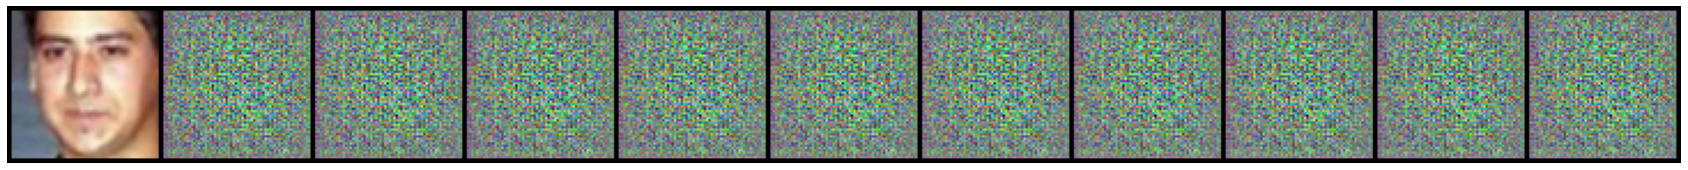

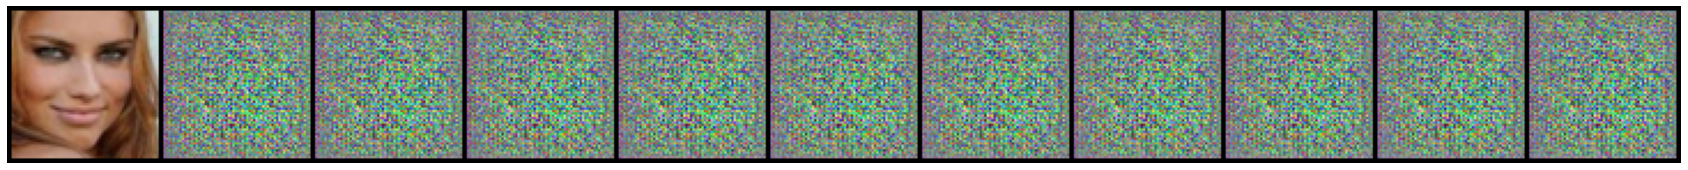

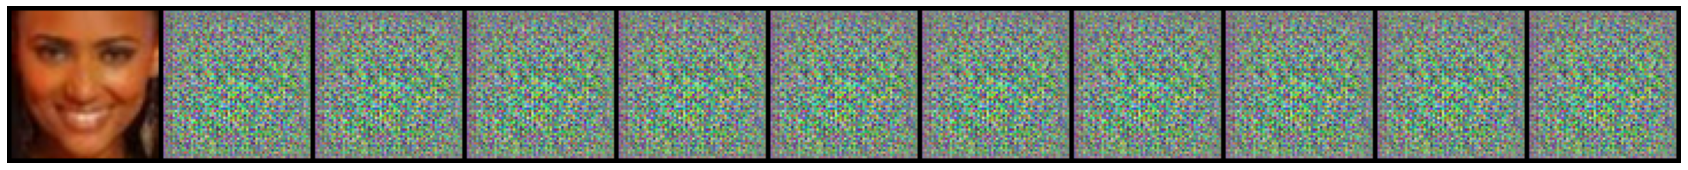

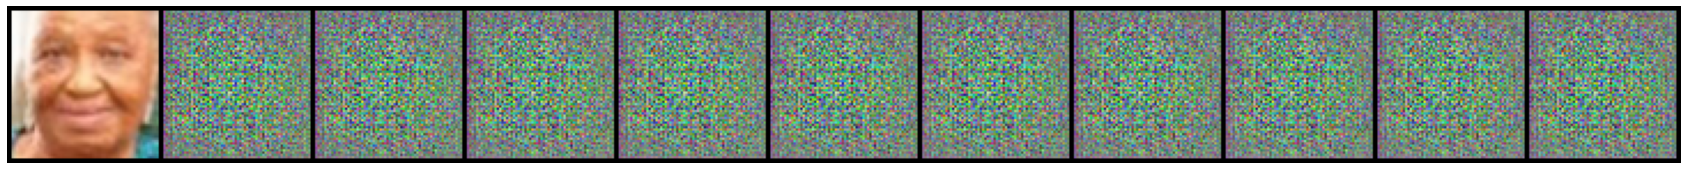

In [17]:
def print_result():
    netG.eval()

    d = next(iter(test_ds))
    real = d[0][:4].to(DEVICE)
    pseudo_label = fixed_pseudo_label()
    # pseudo_label = label_to_image(pseudo_label)

    images = []
    for r in real:
        r = r.unsqueeze(0).repeat(10, 1, 1, 1)
        with torch.no_grad():
            trans = netG(r, pseudo_label).detach()
        img = torch.cat([r[0].unsqueeze(0), trans], dim=0)
        fig = plt.figure(figsize=(30, 30))
        fig.tight_layout()
        plt.axis('off')
        plt.imshow(np.transpose(vutils.make_grid(img, nrow=11, normalize=True).cpu(),(1,2,0)))

    plt.show()

    netG.train()

print_result()

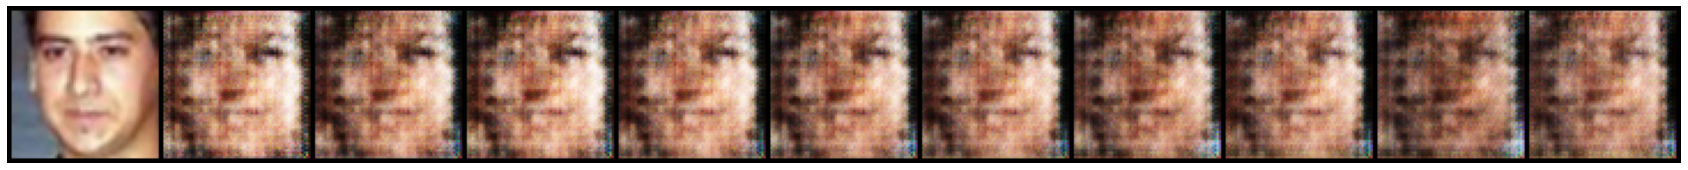

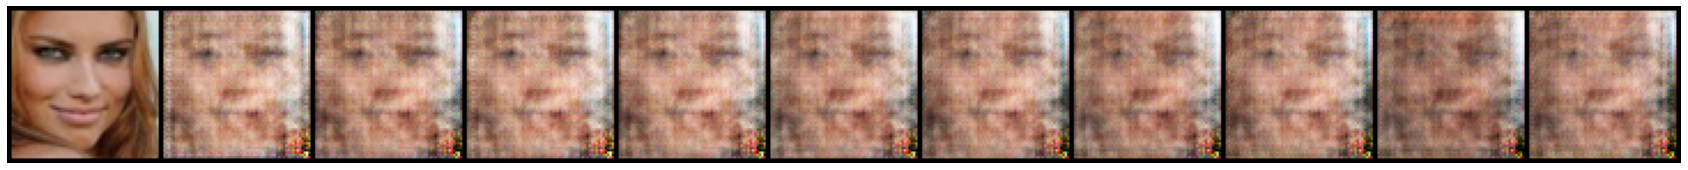

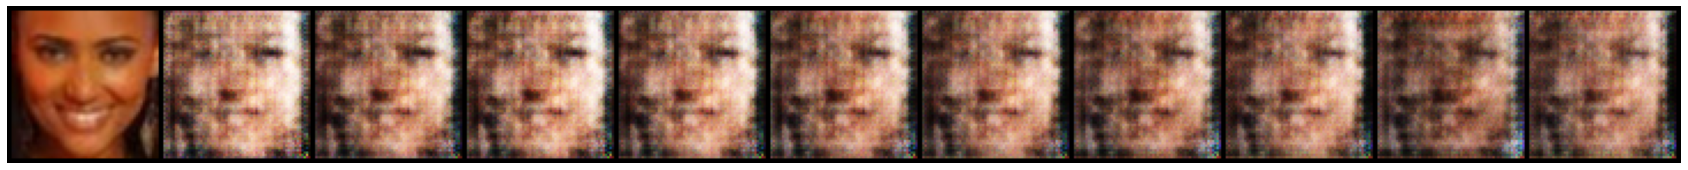

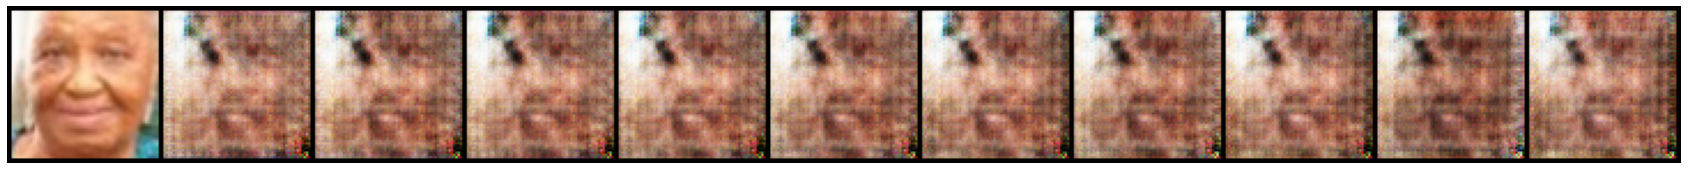

[epoch:7] [iter:87] [Loss_G:2.978240] [Loss_D:0.725884] [Time:0:17:01.358586]

KeyboardInterrupt: ignored

In [19]:
weight_adv = 1
weight_cycle = 1
weight_idt = 1
start_time = datetime.datetime.now()

for epoch in range(EPOCHS):
    for i, data in enumerate(train_ds):
        real = data[0].to(DEVICE)
        real_label = data[1].to(DEVICE)
        # real_label = label_to_image(real_label)

        # Discriminator
        fake_label = make_pseudo_label(real.size(0))
        # fake_label = label_to_image(fake_label)
        fake = netG(real, fake_label)

        pred_real = netD(real, real_label)
        pred_fake = netD(fake.detach(), fake_label)

        y = torch.ones_like(pred_real)

        loss_d = mse(pred_real - pred_fake, y)
        optimizerD.zero_grad()
        loss_d.backward()
        optimizerD.step()

        # Generator
        pred_real = netD(real, real_label)
        pred_fake = netD(fake, fake_label)
        loss_adv = mse(pred_fake - pred_real, y)
        # loss_adv = 0

        rec = netG(fake, real_label)
        loss_cycle = l1(rec, real)
        # loss_cycle = 0

        idt = netG(real, real_label)
        loss_idt = l1(idt, real)
        # loss_idt = 0

        loss_g = loss_adv*weight_adv + loss_cycle*weight_cycle + loss_idt*weight_idt
        optimizerG.zero_grad()
        loss_g.backward()
        optimizerG.step()

        elapsed_time = datetime.datetime.now() - start_time
        print('\r[epoch:{}] [iter:{}] [Loss_G:{:06f}] [Loss_D:{:06f}] [Time:{}]'.format(
            epoch,
            i,
            loss_g.item(),
            loss_d.item(),
            elapsed_time,
            ), end='')
        
    display.clear_output(wait=False)
    print_result()

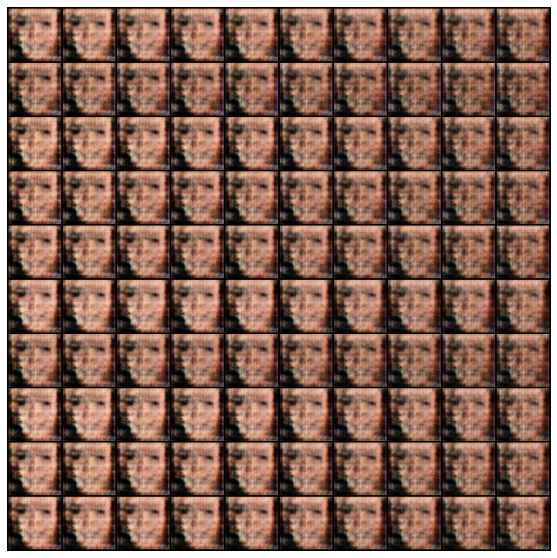

In [21]:
age = np.array([1,5,10,15,20,30,40,50,60,70])
gender = np.eye(2)
race = np.eye(5)
age = np.expand_dims((age - age_mean)/age_std, axis=1)

d = next(iter(test_ds))[0]
real = d[2].to(DEVICE).unsqueeze(0).repeat(len(age),1,1,1)

results = []
for i in range(len(gender)):
    for j in range(len(race)):
        g = np.tile(gender[i], (len(age),1))
        r = np.tile(race[j], (len(age),1))
        label = np.concatenate([age, g, r], axis=1)
        label = torch.Tensor(label).cuda()
        with torch.no_grad():
            trans = netG(real, label).detach()
        results.append(trans)

images = torch.cat(results, dim=0)
fig = plt.figure(figsize=(10, 10))
fig.tight_layout()
plt.axis('off')
plt.imshow(vutils.make_grid(images, nrow=len(age), normalize=True).cpu().permute(1,2,0))